# Задание
Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.

* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить ее в pandas dataframe, а также в excel, pickle, БД

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

*  Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.



In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
class DomIdLoader:
    def __init__(self):
        self.offset_ = 0
        self.limit_ = 50 #00
        self.url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object'

    def get_ids(self):
        paramz = {
            'offset': self.offset_,
            'limit': self.limit_,
            'sortField':'devId.devShortCleanNm',
            'sortType':'asc',
            'objStatus':'0'
        }
        res = requests.get(self.url, params=paramz)
        objects_data = res.json()
        objects_list = objects_data.get('data').get('list')
        objids = [x.get('objId') for x in objects_list]
        return objids

    def show_ids(self):
        print(self.get_ids())

In [23]:
class ObjectInfoExtractor:
    def __init__(self):
        self.objids = DomIdLoader().get_ids()
        self.objects_df = pd.DataFrame()
        self.url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/dictionary/regions'
        self.names = {}

    def load_data(self):
        for i in range(len(self.objids)):
            url_obj = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{self.objids[i]}'
            try:
                res_obj = requests.get(url_obj)
                obj_data = res_obj.json()
                img_list = obj_data.get('data').get('photoRenderDTO')
                res_img = img_list[0].get('objRenderPhotoUrl')
                obj_data.get('data')['img'] = res_img
                self.objects_df = pd.concat([self.objects_df, pd.json_normalize(obj_data.get('data'), max_level=1)])
            except:
                continue
        region = requests.get(self.url).json()
        for reg in region:
            self.names[reg['id']] = reg['name']
        self.objects_df['region'] = self.objects_df['region'].apply(lambda x: self.names[x])
        return self.objects_df.reset_index(drop=True)

In [24]:
class Saver:
    def __init__(self, data):
        self.objects_df = data

    def save_csv(self):
        self.objects_df.to_csv('data.csv')

    def save_json(self):
        self.objects_df.to_json('data.json')

In [25]:
class Visualizer:
    def __init__(self, data):
        self.data = data

    def make_boxplot(self):
        dict_feature_1 = {
            'Средние цены за квадратный метр': 'objPriceAvg',
            'Этажность домов': 'objFloorCnt',
            'Количество квартир': 'objFlatCnt',
            'Жилая площадь дома': 'objSquareLiving',
            'Количество парковочных мест': 'objElemParkingCnt'
        }
        for key, value in dict_feature_1.items():
            mean_feature = self.data.loc[self.data[value].notna()].groupby('region')[value].mean()
            plt.subplots(figsize=(20, 8))
            mean_feature.sort_values().plot(kind='bar')
            plt.title(key)
            
        self.data['objReady100PercDt'] = pd.to_datetime(self.data['objReady100PercDt'], format="%Y/%m/%d")
        self.data.loc[:, 'objReady100PercDt'] = self.data.loc[:, 'objReady100PercDt'].dt.year
        dict_feature_2 = {'Объем вводимого жилья по регионам': 'region',
                          'Объем вводимого жилья по годам': 'objReady100PercDt'}
        for key, value in dict_feature_2.items():
            volume = self.data.groupby(value)[value].count()
            plt.subplots(figsize=(20, 8))
            volume.sort_values().plot(kind='bar')
            plt.title(key)
            
        plt.show()

    def make_heatmap(self):
        df = data[['objPriceAvg', 'objFloorCnt', 'objFlatCnt', 'objSquareLiving', 'objElemParkingCnt']].copy()
        df.rename(columns = {'objPriceAvg' : 'PriceAvg', 'objFlatCnt': 'Flats', 'objFloorCnt' : 'Floors',
                             'objSquareLiving': 'Area', 'objElemParkingCnt': 'Parking'}, inplace = True)
        plt.subplots(figsize=(6, 5))
        sns.heatmap(df[['PriceAvg', 'Floors', 'Flats', 'Area', 'Parking']].corr(), linewidths=.01, cmap='coolwarm', annot=True)
        plt.title('Тепловая карта')
        plt.show()

In [26]:
data = ObjectInfoExtractor().load_data()
data.head()

,id,pdId,region,address,floorMin,floorMax,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,...,developer.orgBankruptMsgDttm,complexShortNm,greenAreaIndexValue,metro.id,metro.name,metro.line,metro.color,metro.time,metro.isWalk,metro.colors
0,13383,28105,Тюменская область,г Тюмень,4,20,68,2022-12-31,Другое,По желанию заказчика,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13397,28141,Тюменская область,"г Тюмень, ул Профсоюзная, д. 56",6,12,65,2024-12-31,Другое,Без отделки,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13398,28141,Тюменская область,"г Тюмень, ул Профсоюзная, д. 56",7,10,43,2024-12-31,Другое,Без отделки,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13399,28141,Тюменская область,"г Тюмень, ул Профсоюзная, д. 56",1,1,0,2024-12-31,Другое,Без отделки,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13391,28101,Тюменская область,"г Тюмень, ул Профсоюзная",3,12,44,2022-12-31,Другое,По желанию заказчика,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
Saver(data).save_json()

In [28]:
data = pd.read_csv('Data.csv')

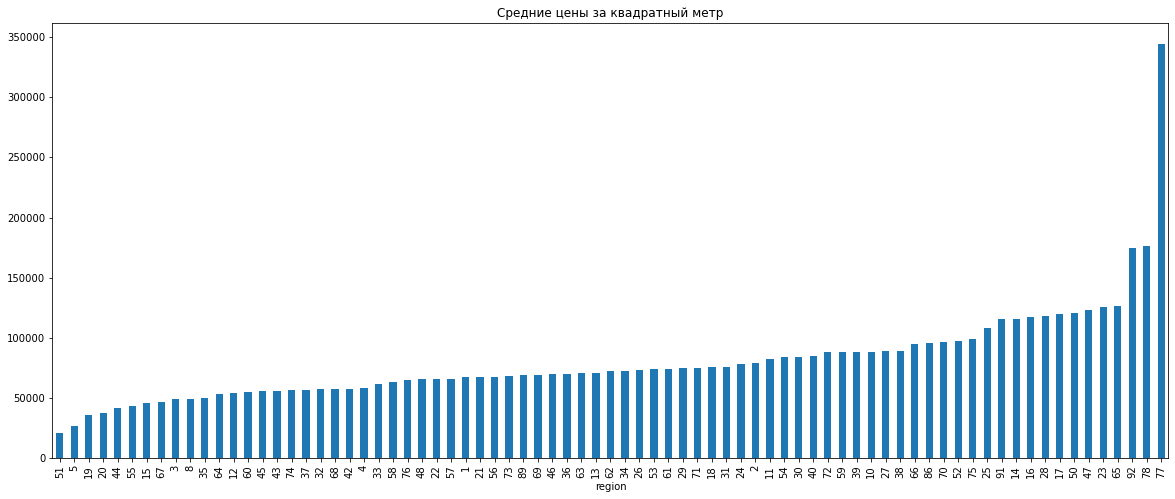

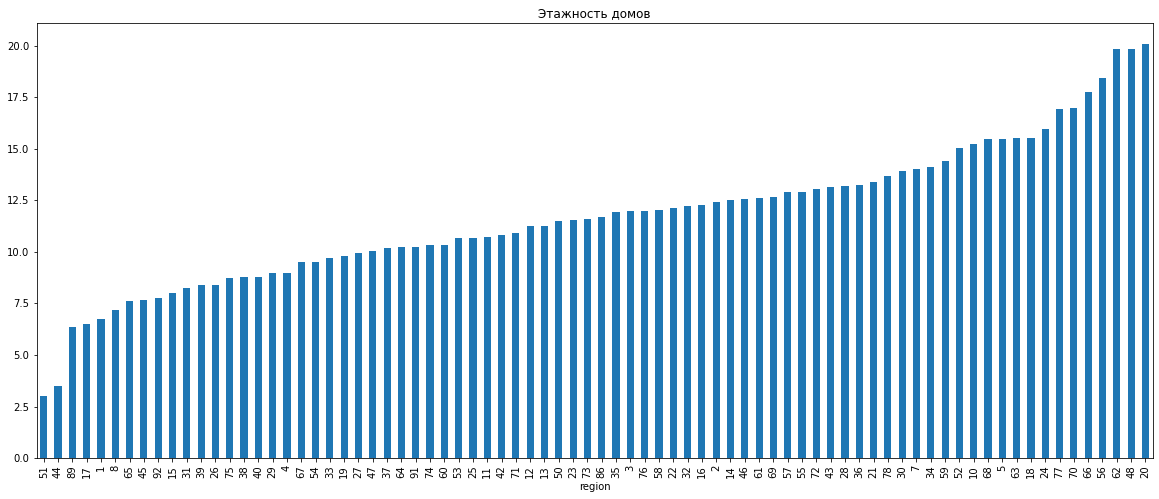

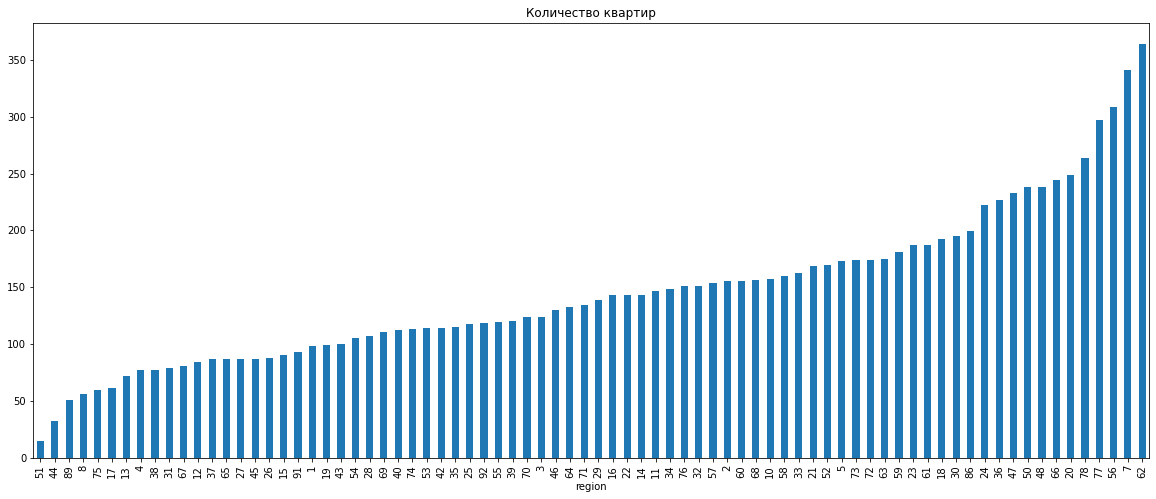

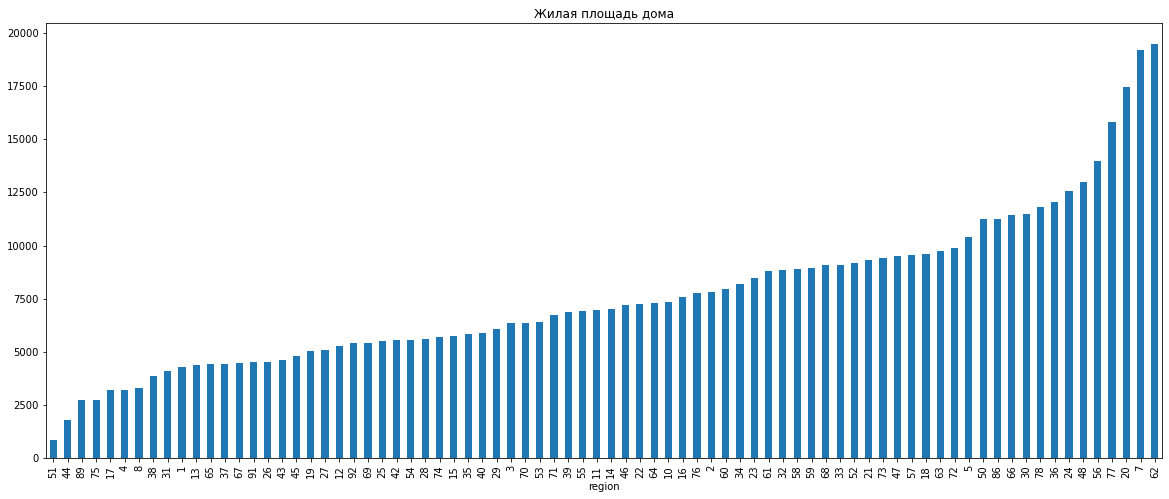

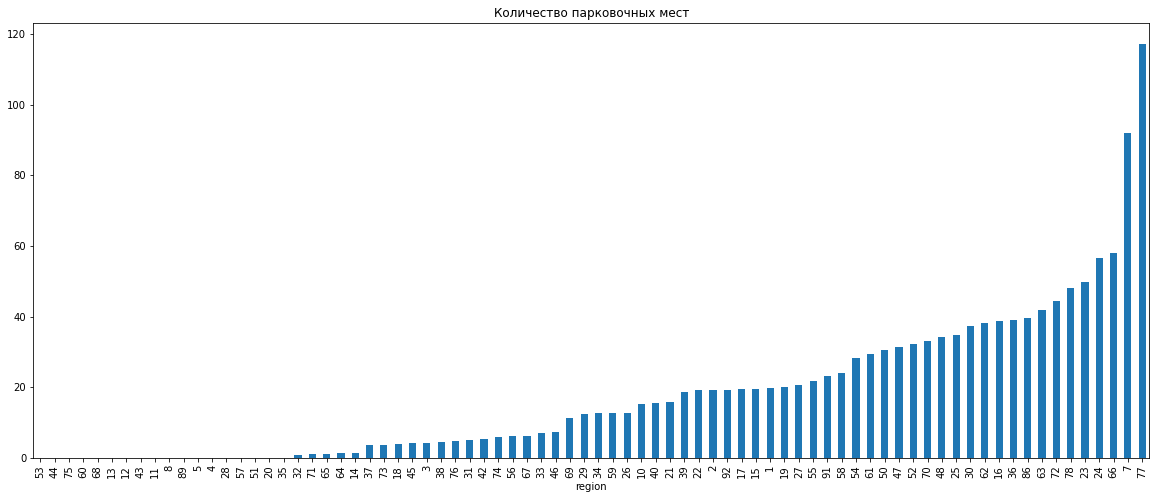

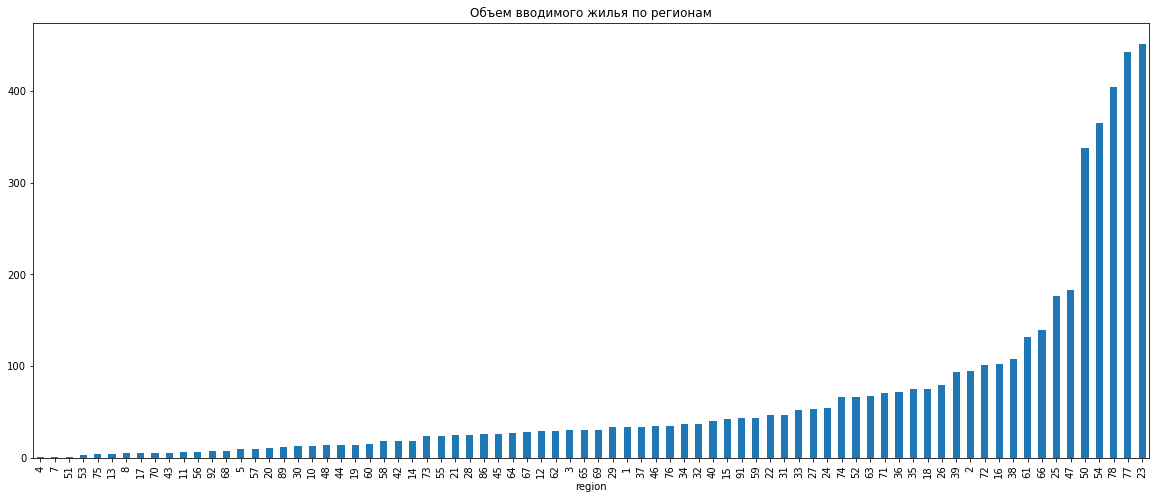

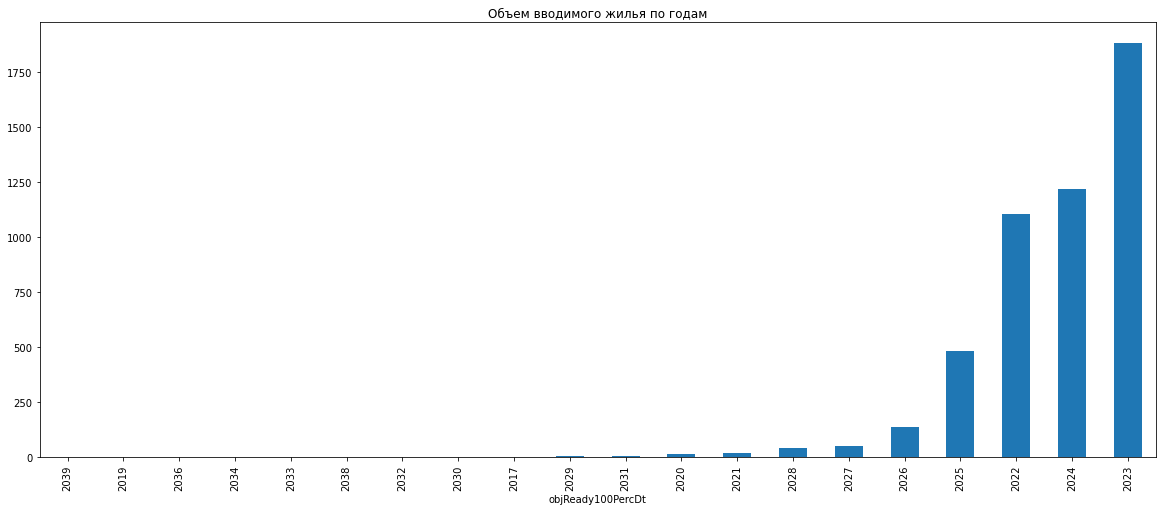

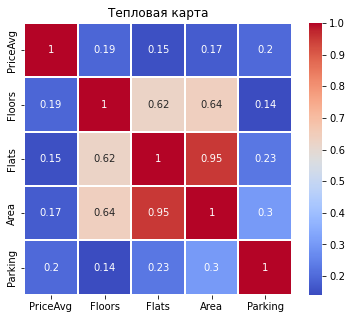

In [29]:
shape = Visualizer(data)
shape.make_boxplot()
shape.make_heatmap()